# News Headline EDA

In [1]:
# importing all my dependancies
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import string
import re

In [2]:
df = pd.read_csv('../data/scrape_news_articles.csv', sep=";", index_col=[0])
df.head()

,topic,link,domain,published_date,title,lang
0,LIFESTYLE,https://www.politico.com/newsletters/politico-...,politico.com,2022-03-08 15:45:00,Moderna eases up on vaccine patent protections,en
1,LIFESTYLE,https://stylecaster.com/queen-elizabeth-lilibet,stylecaster.com,2022-03-08 15:10:14,The Queen ‘Desperately' Wants to Meet Lilibet—...,en
2,LIFESTYLE,https://stylecaster.com/kim-kardashian-kanye-p...,stylecaster.com,2022-03-08 14:45:04,Here's What Kim Really Thinks of Kanye's ‘Dist...,en
3,LIFESTYLE,https://www.complex.com/style/novesta-ss22,complex.com,2022-03-08 14:44:22,Novesta Unveils Colourful Spring/Summer 2022 F...,en
4,LIFESTYLE,https://www.qatarliving.com/forum/fashion/ladi...,qatarliving.com,2022-03-08 13:50:35,Ladies! Dress up with the Perfect Dresses from...,en


In [3]:
df2 = pd.read_csv('../data/labeled_newscatcher_dataset.csv', sep=";")

In [4]:
corpus = pd.concat([df, df2], ignore_index=True)
corpus.shape

(140767, 6)

In [5]:
corpus.head()

,topic,link,domain,published_date,title,lang
0,LIFESTYLE,https://www.politico.com/newsletters/politico-...,politico.com,2022-03-08 15:45:00,Moderna eases up on vaccine patent protections,en
1,LIFESTYLE,https://stylecaster.com/queen-elizabeth-lilibet,stylecaster.com,2022-03-08 15:10:14,The Queen ‘Desperately' Wants to Meet Lilibet—...,en
2,LIFESTYLE,https://stylecaster.com/kim-kardashian-kanye-p...,stylecaster.com,2022-03-08 14:45:04,Here's What Kim Really Thinks of Kanye's ‘Dist...,en
3,LIFESTYLE,https://www.complex.com/style/novesta-ss22,complex.com,2022-03-08 14:44:22,Novesta Unveils Colourful Spring/Summer 2022 F...,en
4,LIFESTYLE,https://www.qatarliving.com/forum/fashion/ladi...,qatarliving.com,2022-03-08 13:50:35,Ladies! Dress up with the Perfect Dresses from...,en


In [6]:
# checking for nulls
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140767 entries, 0 to 140766
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   topic           140767 non-null  object
 1   link            140767 non-null  object
 2   domain          140767 non-null  object
 3   published_date  140767 non-null  object
 4   title           140767 non-null  object
 5   lang            140767 non-null  object
dtypes: object(6)
memory usage: 6.4+ MB


In [7]:
corpus['domain'].value_counts()

dailymail.co.uk                1855
theguardian.com                1439
express.co.uk                  1403
newser.com                     1338
timesofindia.indiatimes.com    1313
                               ... 
brokernews.com.au                 1
travelmarketreport.com            1
laughingsquid.com                 1
thepublicopinion.com              1
gainesville.com                   1
Name: domain, Length: 7714, dtype: int64

In [8]:
# As we can see here, the class imbalance could cause an issue later 
# I scraped more data here
corpus['topic'].value_counts()

ENTERTAINMENT    18100
WORLD            15000
NATION           15000
TECHNOLOGY       15000
BUSINESS         15000
HEALTH           15000
SPORTS           15000
SCIENCE          13774
GAMING           10000
LIFESTYLE         8893
Name: topic, dtype: int64

C:\Users\deaud\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


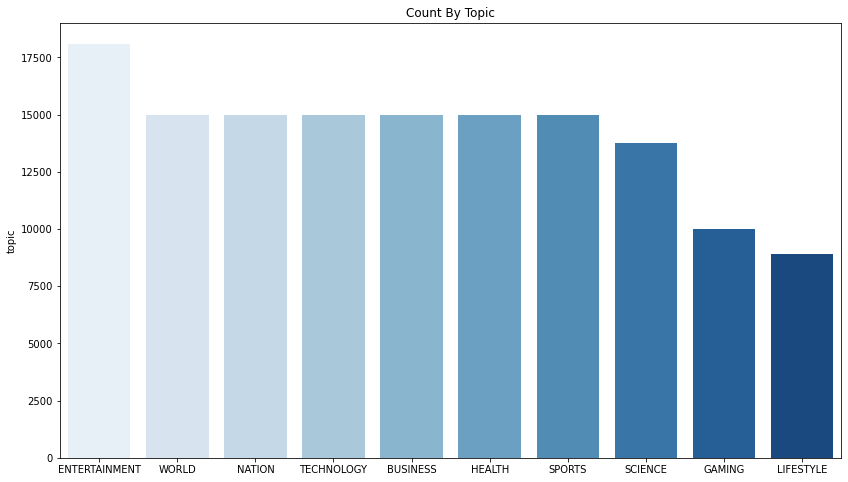

In [9]:
x = corpus["topic"].value_counts()
plt.figure(figsize=(14,8))
sns.barplot(x.index, x, palette='Blues')
plt.title("Count By Topic");

In [10]:
# checking the language of all the data (although not always accurate)
corpus['lang'].value_counts()

en    140767
Name: lang, dtype: int64

In [11]:
# checking out the titles
corpus.loc[100].title

'11 Best Eyelash Curlers'

## Data Cleaning and EDA 

In [12]:
# cleaning my test data
sw = stopwords.words('english') + list(string.punctuation)

corpus.title = [word.lower() for word in corpus.title]
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
corpus.title = [nltk.regexp_tokenize(line, pattern) for line in corpus.title]
lemma = WordNetLemmatizer()
corpus.title= [[lemma.lemmatize(word) for word in line] for line in corpus.title]
corpus.title = [[word for word in line if word not in sw] for line in corpus.title]

In [13]:
corpus.title

0               [moderna, eas, vaccine, patent, protection]
1         [queen, desperately, want, meet, lilibet, here...
2         [here's, kim, really, think, kanye's, disturbi...
3         [novesta, unveils, colourful, spring, summer, ...
4               [lady, dress, perfect, dress, store, qatar]
                                ...                        
140762    [pdp, governor, forum, urge, security, agency,...
140763    [q, apple, dominated, premium, smartphone, seg...
140764    [coronavirus, northern, ireland, full, breakdo...
140765    [paul, mccartney, detail, post, beatles, distr...
140766    [report, talk, underway, keep, shane, duffy, p...
Name: title, Length: 140767, dtype: object

In [14]:
from textblob import TextBlob, Word
from wordcloud import WordCloud

In [15]:
dict_of_topics = {}

for topic in corpus.topic.unique():
    current_corpus = corpus.loc[corpus['topic'] == topic]
    dict_of_topics[topic] = list(current_corpus.title)

In [16]:
dict_of_topics

{'LIFESTYLE': [['moderna', 'eas', 'vaccine', 'patent', 'protection'],
  ['queen',
   'desperately',
   'want',
   'meet',
   'lilibet',
   "here's",
   'could',
   'happen',
   'covid',
   'diagnosis'],
  ["here's",
   'kim',
   'really',
   'think',
   "kanye's",
   'disturbing',
   'music',
   'video',
   'pete',
   'amid',
   'divorce'],
  ['novesta',
   'unveils',
   'colourful',
   'spring',
   'summer',
   'footwear',
   'capsule'],
  ['lady', 'dress', 'perfect', 'dress', 'store', 'qatar'],
  ['beautiful', 'cool', 'today'],
  ['hunt', 'wild', 'ginseng', 'changed', 'america'],
  ['unhappy',
   'young',
   'restless',
   'fan',
   'take',
   'show',
   'task',
   "jack's",
   'storyline',
   'depressing',
   'sod',
   "he's",
   'lately'],
  ['moderna', 'era', 'b', 'value', 'rout', 'deepens'],
  ['camila',
   'cabello',
   'spoke',
   'candidly',
   'shawn',
   'mendes',
   'breakup',
   'releasing',
   'single',
   'bam',
   'bam'],
  ['international',
   "women's",
   'day',
   '

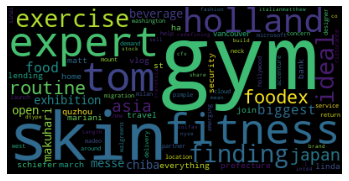

<Figure size 1440x720 with 0 Axes>

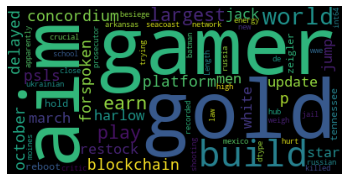

<Figure size 1440x720 with 0 Axes>

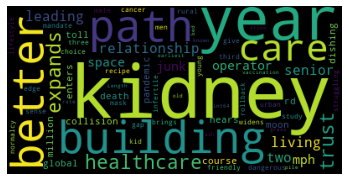

<Figure size 1440x720 with 0 Axes>

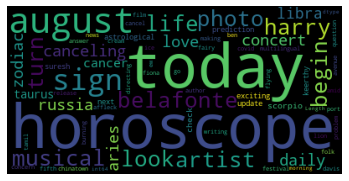

<Figure size 1440x720 with 0 Axes>

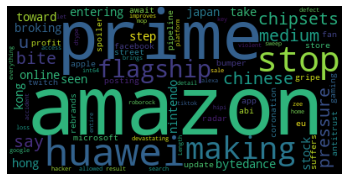

<Figure size 1440x720 with 0 Axes>

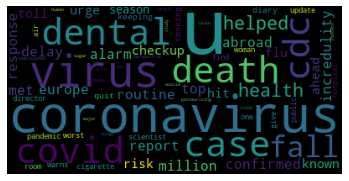

<Figure size 1440x720 with 0 Axes>

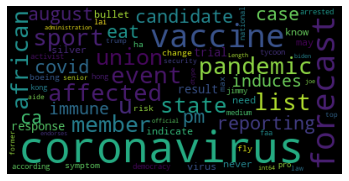

<Figure size 1440x720 with 0 Axes>

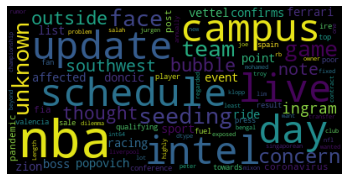

<Figure size 1440x720 with 0 Axes>

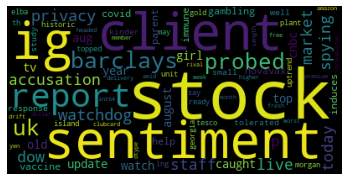

<Figure size 1440x720 with 0 Axes>

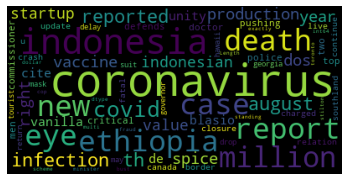

<Figure size 1440x720 with 0 Axes>

In [17]:
for name, values in dict_of_topics.items():
    counts = pd.Series(dict_of_topics[name]).value_counts()
    wordcloud= WordCloud(max_words=100, width=400, height=200).generate(str(counts))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.figure(figsize=(20,10))
    #plt.title(name)
    plt.show()

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

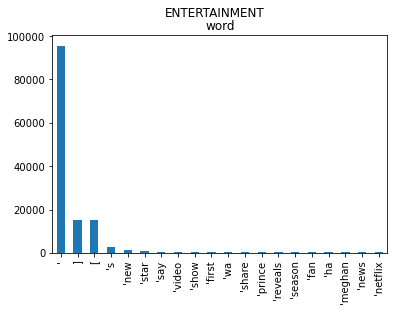

In [36]:
blob = TextBlob(str(dict_of_topics['ENTERTAINMENT']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[:20]
word_df.plot(kind='bar', title='ENTERTAINMENT', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

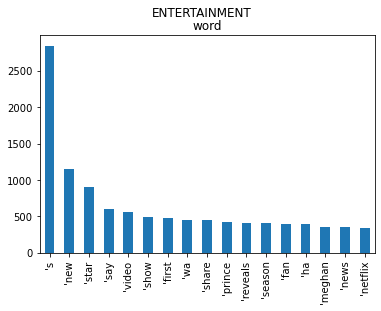

In [35]:
blob = TextBlob(str(dict_of_topics['ENTERTAINMENT']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='ENTERTAINMENT', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

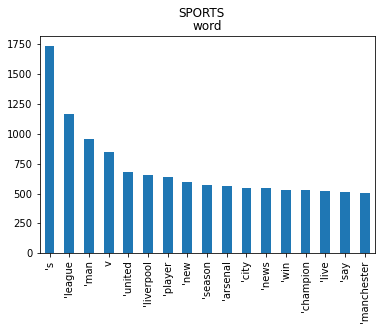

In [34]:
blob = TextBlob(str(dict_of_topics['SPORTS']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='SPORTS', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

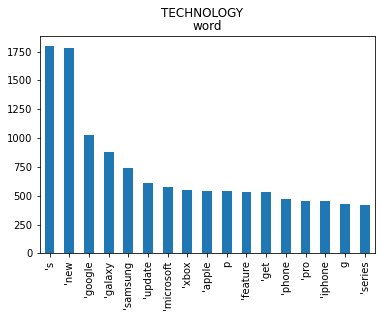

In [33]:
blob = TextBlob(str(dict_of_topics['TECHNOLOGY']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='TECHNOLOGY', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

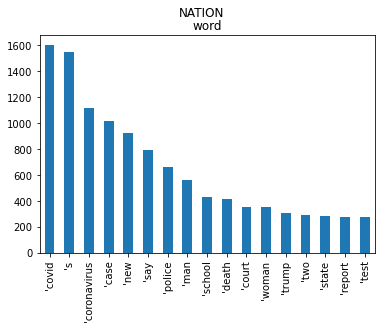

In [32]:
blob = TextBlob(str(dict_of_topics['NATION']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='NATION', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

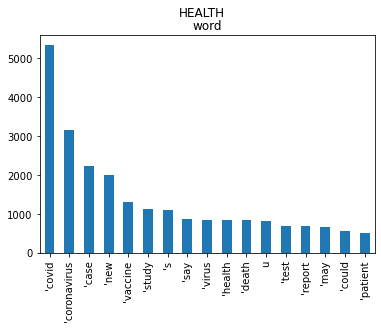

In [31]:
blob = TextBlob(str(dict_of_topics['HEALTH']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='HEALTH', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

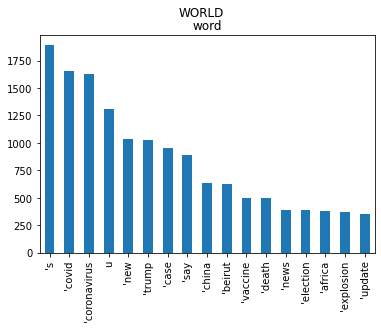

In [30]:
blob = TextBlob(str(dict_of_topics['WORLD']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='WORLD', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

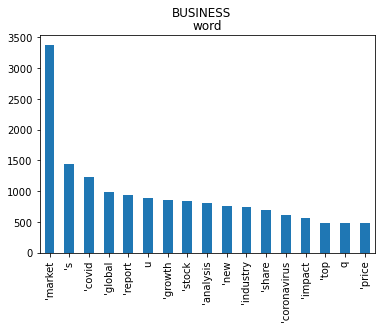

In [29]:
blob = TextBlob(str(dict_of_topics['BUSINESS']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='BUSINESS', subplots=True)

array([<AxesSubplot:title={'center':'word'}>], dtype=object)

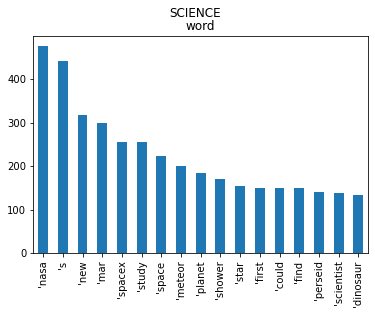

In [28]:
blob = TextBlob(str(dict_of_topics['SCIENCE']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
word_df = pos_df.word.value_counts()[3:20]
word_df.plot(kind='bar', title='SCIENCE', subplots=True)